In [1]:
pip install numpy networkx matplotlib  scipy pandas

In [2]:
pip install pulser pulser-simulation

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.9/220.9 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.1/30.1 MB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.6/122.6 kB 5.2 MB/s eta 0:00:00


In [3]:
import numpy as np
import networkx as nx
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.optimize import minimize
import pandas as pd

from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipEmulator
from pulser.waveforms import InterpolatedWaveform
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform



Improved CO2 Hydrogenation Optimization
Number of species: 6
Number of reaction pathways: 6

Top 5 Solutions by QUBO Cost:
-----------------------------
1. 111001 (QUBO Cost: -39.00)
   Overall Score: 11.77
   Weight Score: 8.77
   Connection Score: 3
   Avg Pathway Weight: 0.123
   Selected Nodes: [0, 1, 2, 5]
   Active Pathways: 3
   Selected Species: 0: 0, 1: 1, 2: 2, 5: 5

2. 101011 (QUBO Cost: -34.80)
   Overall Score: 8.50
   Weight Score: 7.50
   Connection Score: 1
   Avg Pathway Weight: 0.250
   Selected Nodes: [0, 2, 4, 5]
   Active Pathways: 1
   Selected Species: 0: 0, 2: 2, 4: 4, 5: 5

3. 111000 (QUBO Cost: -34.20)
   Overall Score: 11.40
   Weight Score: 9.40
   Connection Score: 2
   Avg Pathway Weight: 0.060
   Selected Nodes: [0, 1, 2]
   Active Pathways: 2
   Selected Species: 0: 0, 1: 1, 2: 2

4. 110001 (QUBO Cost: -33.60)
   Overall Score: 10.80
   Weight Score: 9.80
   Connection Score: 1
   Avg Pathway Weight: 0.020
   Selected Nodes: [0, 1, 5]
   Active Pathways

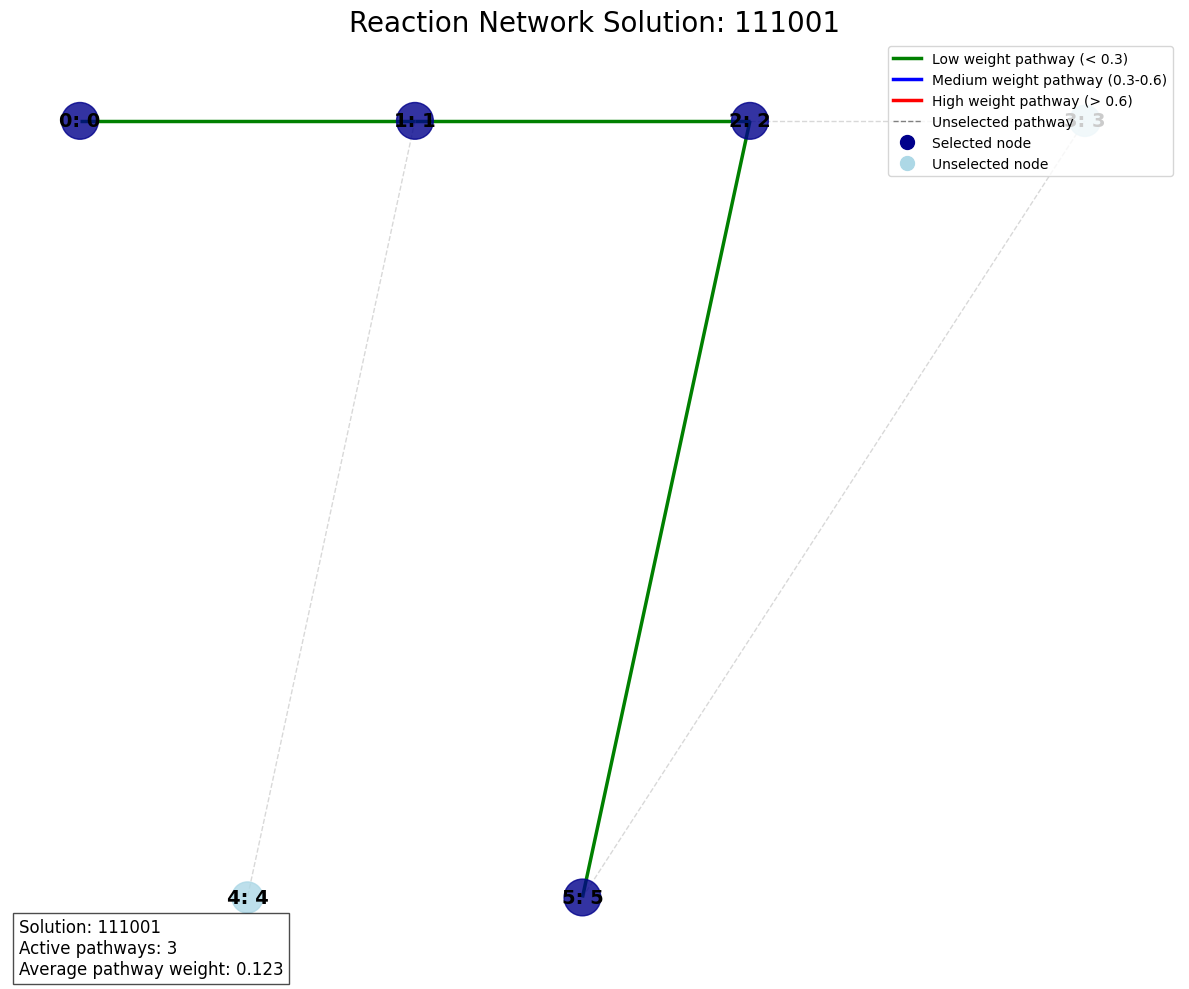

In [4]:
def lambda_fun(weight, lambda_min=0.3, lambda_max=2):
    """Penalization function for reaction pathways based directly on weights.
        Args:
        weight: (float) Weight value for the pathway
        lambda_min: minimum penalization for favorable pathways
        lambda_max: maximum penalization for unfavorable pathways

        Return:
            lambda_ij: (float) Penalization for the given pathway
    """
    # Invert the relationship: lower weights should give lower lambda values
    # Higher weights should give higher lambda values
    if weight <= 0.01:  # Very low weight (very favorable)
        return lambda_min
    elif weight >= 0.9:  # Very high weight (very unfavorable)
        return lambda_max
    else:
        # Linear interpolation between lambda_min and lambda_max
        normalized_weight = (weight - 0.01) / (0.9 - 0.01)
        lambda_value = lambda_min + normalized_weight * (lambda_max - lambda_min)
        return round(lambda_value, 2)


def visualize_solution(G, solution_bitstring, pos=None, lambda_ij=None, weight_dict=None, Q=None):
    """Visualize a specific solution to the CO2 hydrogenation problem with edge coloring based solely on weights.

    Args:
        G (networkx.Graph): The reaction network graph
        solution_bitstring (str): Binary string representing the solution
        pos (dict): Optional node positions
        lambda_ij (dict): Dictionary of lambda values for each pathway
        weight_dict (dict): Dictionary of weights for each pathway
        Q (np.array): QUBO matrix used for optimization
    """
    import matplotlib.pyplot as plt
    import networkx as nx
    import numpy as np

    solution = [int(bit) for bit in solution_bitstring]

    if pos is None:
        pos = nx.spring_layout(G, seed=42)

    plt.figure(figsize=(12, 10))

    # Get node labels
    labels = {}
    for node in G.nodes():
        labels[node] = G.nodes[node].get('name', f"Species_{node}")

    # Determine node colors based on selection only
    node_colors = ['darkblue' if solution[n] == 1 else 'lightblue' for n in G.nodes()]

    # Draw nodes with appropriate colors and sizes
    nx.draw_networkx_nodes(G, pos, node_size=[700 if solution[n] == 1 else 500 for n in G.nodes()],
                           node_color=node_colors, alpha=0.8)

    # Draw edges with different styles based on whether both end nodes are selected
    selected_edges = [(i, j) for i, j in G.edges() if solution[i] == 1 and solution[j] == 1]
    other_edges = [(i, j) for i, j in G.edges() if (i, j) not in selected_edges]

    # Draw selected edges with coloring based solely on weight
    if selected_edges:
        for u, v in selected_edges:
            weight = weight_dict.get((u, v), 0.5) if weight_dict else 0.5

            # Color based on weight - from green (low weight) to red (high weight)
            if weight < 0.3:
                edge_color = 'green'  # Low weight (more favorable)
            elif weight < 0.6:
                edge_color = 'blue'   # Medium weight
            else:
                edge_color = 'red'    # High weight (less favorable)

            # Width is uniform for all selected edges
            width = 2.5

            # Draw the edge with selected properties
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=width,
                                  edge_color=edge_color, style='solid')

    # Draw other edges (thin, dashed lines)
    nx.draw_networkx_edges(G, pos, edgelist=other_edges, width=1.0,
                          edge_color='gray', style='dashed', alpha=0.3)

    # Draw labels
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=14, font_weight='bold')

    # Add simplified legend explaining the coloring scheme
    legend_elements = [
        plt.Line2D([0], [0], color='green', lw=2.5, label='Low weight pathway (< 0.3)'),
        plt.Line2D([0], [0], color='blue', lw=2.5, label='Medium weight pathway (0.3-0.6)'),
        plt.Line2D([0], [0], color='red', lw=2.5, label='High weight pathway (> 0.6)'),
        plt.Line2D([0], [0], color='gray', lw=1, linestyle='dashed', label='Unselected pathway'),
        plt.Line2D([0], [0], marker='o', color='darkblue', markersize=10, linestyle='', label='Selected node'),
        plt.Line2D([0], [0], marker='o', color='lightblue', markersize=10, linestyle='', label='Unselected node')
    ]
    plt.legend(handles=legend_elements, loc='upper right', fontsize=10)

    # Add solution evaluation summary if available
    if weight_dict is not None:
        # Calculate statistics about the solution based solely on weights
        active_pathways = [(i, j) for i, j in G.edges() if solution[i] == 1 and solution[j] == 1]
        avg_weight = sum(weight_dict.get((i, j), 0.5) for i, j in active_pathways) / len(active_pathways) if active_pathways else 0

        # Add text annotation with solution summary
        summary_text = f"Solution: {solution_bitstring}\n"
        summary_text += f"Active pathways: {len(active_pathways)}\n"
        summary_text += f"Average pathway weight: {avg_weight:.3f}"

        plt.figtext(0.02, 0.02, summary_text, fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

    plt.title(f"Reaction Network Solution: {solution_bitstring}", fontsize=20)
    plt.axis('off')
    plt.tight_layout()

    return plt.gcf()


# Create improved CO2 hydrogenation example with updated network structure
def create_improved_co2_hydrogenation_example():
    import networkx as nx
    import numpy as np

    # Define reaction network species with the new sequence from the diagram
    species_names = [
        "0",           # 0: starting material
        "1",          # 1: intermediate (changed from CO2)
        "2",           # 2: formyl intermediate (changed from HCOO)
        "3",          # 3: methoxy intermediate (moved up in sequence)
        "4",            # 4: carbon monoxide (undesired byproduct)
        "5",           # 5: methane (undesired byproduct)
    ]
    # Create graph manually for this specific network
    G = nx.Graph()

    # Add nodes with descriptive names and correct node numbers
    for i, name in enumerate(species_names):

            G.add_node(i, name=f"{i}: {name}")



    G.add_edge(0, 1)  # CO2 → HCOO
    G.add_edge(1, 2)  # HCOO → HCO
    G.add_edge(2, 3)  # HCO → CH3O
   # G.add_edge(3, 6)  # CH3O → CH3OH

    # Undesired pathways
    G.add_edge(1, 4)  # CO2 → CO (competing reaction)
    G.add_edge(2, 5)  # HCO → CH4 (competing reaction)
 #   G.add_edge(4, 2)  # HCO → CH4 (competing reaction)
    G.add_edge(5, 3)  # HCO → CH4 (competing reaction)

    # UPDATED: Weights based on the provided values
    weights = {
        (0, 1): 0.02,
        (1, 2): 0.1,  # CO2 → HCO (w*{12})
        (1, 4): 0.997562,    # CO2 → CO (w*{13})
        (2, 3): 0.75,  # HCO → CH3O (w*{24})
        (2, 5): 0.25,    # HCO → CH4 (w*{25})
        (3,5): 10 # CH3O → CH3OH (assuming full conversion)
    }

    # Add symmetric values
    for (i, j), value in list(weights.items()):
        weights[(j, i)] = value

    # Calculate lambda values and QUBO matrix using improved function
    lambda_ij, Q = set_improved_problem(G, weights)

    # Visualize the reaction network
    pos = visualize_hydrogenation_network(G, lambda_ij, weights)

    return G, lambda_ij, Q, weights, pos


# Corrected analyze_pathway_completeness function for the new network
def analyze_pathway_completeness(G, solution_bitstring):
    """Analyze whether a solution contains complete reaction pathways from CO2 to products.

    Args:
        G (networkx.Graph): The reaction network graph
        solution_bitstring (str): Binary string representing the solution

    Returns:
        dict: Analysis of pathway completeness
    """
    solution = [int(bit) for bit in solution_bitstring]
    selected_nodes = [i for i, bit in enumerate(solution) if bit == 1]

    # Updated main pathway from CO2 to methanol based on new network
    main_pathway =  [0, 1, 2, 3, 6] # CO2 → HCO → CH3O → CH3OH

    # Check if all nodes in the main pathway are selected
    main_pathway_complete = all(node in selected_nodes for node in main_pathway)

    # Check if all connections in the main pathway are possible
    main_connections_possible = True
    for i in range(len(main_pathway)-1):
        if main_pathway[i] not in selected_nodes or main_pathway[i+1] not in selected_nodes:
            main_connections_possible = False
            break

    # Identify missing steps in the main pathway
    missing_steps = []
    for i in range(len(main_pathway)):
        if main_pathway[i] not in selected_nodes:
            node_name = G.nodes[main_pathway[i]].get('name', f"Species_{main_pathway[i]}")
            missing_steps.append(node_name)

    # Check for byproduct formation pathways
    byproduct_pathways = []
    byproduct_nodes = [4, 5]  # CO, CH4 - Updated node numbers

    for byproduct in byproduct_nodes:
        if byproduct in selected_nodes:
            # Find connections to this byproduct
            for neighbor in G.neighbors(byproduct):
                if neighbor in selected_nodes:
                    source_name = G.nodes[neighbor].get('name', f"Species_{neighbor}")
                    byproduct_name = G.nodes[byproduct].get('name', f"Species_{byproduct}")
                    byproduct_pathways.append(f"{source_name} → {byproduct_name}")

    return {
        "main_pathway_complete": main_pathway_complete,
        "main_connections_possible": main_connections_possible,
        "missing_steps": missing_steps,
        "byproduct_pathways": byproduct_pathways,
        "chemical_feasibility": "High" if main_pathway_complete else
                              "Medium" if main_connections_possible else
                              "Low"
    }


def set_improved_problem(G, weights, strength=10):
    """Return lambda_ij terms and Q matrix for the CO2 hydrogenation problem
    based solely on edge weights without any predetermined pathway preferences.

    Args:
        G (networkx graph): Graph that represent the reaction network
        weights (dict): Dictionary with weights for each pathway
        strength (float): Amplification of the signal

    Return:
        lambda_ij (dict): keys:(species_1, species_2) Values: lambda values
        Q (np.array): Q matrix of the QUBO.
    """
    import numpy as np

    n_nodes = len(G.nodes)
    Q = np.zeros((n_nodes, n_nodes))
    lambda_ij = {}

    # Set uniform diagonal elements - encourage all nodes to be selected
    for i in range(n_nodes):
        Q[i, i] = -1 * strength

    # Process edges based purely on edge weights
    for i, j in G.edges:
        # Get pathway weight with default if not provided
        weight = weights.get((i, j), 0.5)

        # Calculate lambda value based on weight
        lambda_val = lambda_fun(weight)
        lambda_ij[(i, j)] = lambda_val

        # Directly use the lambda value as the coefficient in the QUBO
        # Lower weights mean more favorable reactions (lower lambda)
        pathway_weight = strength * lambda_val

        # Populate Q matrix symmetrically
        Q[i, j] = pathway_weight
        Q[j, i] = pathway_weight

    # Add general connectivity incentive - reward connected solutions
    # This adds a small incentive for edges where both nodes are selected
    connectivity_strength = 0.5 * strength
    for i, j in G.edges:
        # This adds a negative term to the energy when both nodes are selected
        Q[i, j] -= connectivity_strength
        Q[j, i] -= connectivity_strength

    return lambda_ij, Q


# Function to visualize the hydrogenation network (placeholder)
def visualize_hydrogenation_network(G, lambda_ij, weight_dict):
    import networkx as nx

    # Simple positioning function
    pos = nx.spring_layout(G, seed=42)

    # Custom positioning for clearer visualization
    # Manually adjust positions for clearer display
    pos[0] = np.array([-1, 0])     # CO2
    pos[1] = np.array([0, 0])      # HCO0
    pos[2] = np.array([1, 0])      # HCO
    pos[3] = np.array([2, 0])      # CH3O
   # pos[6] = np.array([3, 0])      # CH3OH (product)
    pos[4] = np.array([-0.5, -1])  # CO (byproduct)
    pos[5] = np.array([0.5, -1])   # CH4 (byproduct)

    return pos


# Update evaluate_chemical_solution function
def evaluate_chemical_solution(G, lambda_ij, weight_dict, solution_bitstring, cost):
    """Evaluate a solution based purely on pathway weights without assumptions about desired pathways.

    Args:
        G (networkx.Graph): The reaction network graph
        lambda_ij (dict): Dictionary of lambda values for pathways
        weight_dict (dict): Dictionary of weights for pathways
        solution_bitstring (str): Binary string representing the solution
        cost (float): The calculated cost of the solution

    Returns:
        dict: Evaluation of the solution
    """
    # Basic solution analysis
    basic_analysis = analyze_hydrogenation_solution(G, solution_bitstring)

    # Convert solution to node list
    solution = [int(bit) for bit in solution_bitstring]
    selected_nodes = [i for i, bit in enumerate(solution) if bit == 1]

    # Calculate weight-based score (lower weights are better)
    active_pathways = basic_analysis["active_pathways"]
    total_pathway_weight = sum(weight_dict.get((i, j), 0.5) for i, j in active_pathways) if active_pathways else 0
    avg_pathway_weight = total_pathway_weight / len(active_pathways) if active_pathways else 0

    # Calculate a weight-based score (inverse of average weight)
    weight_score = 10 * (1 - avg_pathway_weight) if active_pathways else 0

    # Count total connections
    connection_score = len(active_pathways)

    # Overall score based solely on weights and connectivity
    overall_score = weight_score + connection_score

    return {
        "solution_bitstring": solution_bitstring,
        "qubo_cost": cost,
        "weight_score": weight_score,
        "connection_score": connection_score,
        "overall_score": overall_score,
        "avg_pathway_weight": avg_pathway_weight,
        "selected_nodes": selected_nodes,
        "active_pathways": len(active_pathways),
        "selected_species": basic_analysis["selected_species_names"]
    }
# Helper function to analyze hydrogenation solution
def analyze_hydrogenation_solution(G, solution_bitstring):
    """Analyze basic properties of a solution.

    Args:
        G (networkx.Graph): The reaction network graph
        solution_bitstring (str): Binary string representing the solution

    Returns:
        dict: Basic analysis of the solution
    """
    solution = [int(bit) for bit in solution_bitstring]
    selected_nodes = [i for i, bit in enumerate(solution) if bit == 1]

    # Get selected species names
    selected_species_names = []
    for node in selected_nodes:
        selected_species_names.append(G.nodes[node].get('name', f"Species_{node}"))

    # Find active pathways (edges between selected nodes)
    active_pathways = []
    for i, j in G.edges():
        if i in selected_nodes and j in selected_nodes:
            active_pathways.append((i, j))

    # Identify products and byproducts
    products_included = []
    byproducts_included = []
    for node in selected_nodes:
        node_name = G.nodes[node].get('name', '')
        if 'product' in node_name.lower() and 'byproduct' not in node_name.lower():
            products_included.append(node)
        elif 'byproduct' in node_name.lower():
            byproducts_included.append(node)

    return {
        "selected_nodes": selected_nodes,
        "selected_species_names": selected_species_names,
        "active_pathways": active_pathways,
        "products_included": products_included,
        "byproducts_included": byproducts_included
    }


# Brute force solver for finding optimal solutions
def improved_brute_force_solution(G, Q, lambda_ij, weight_dict):
    """Find optimal solutions using brute force with weight-based evaluation.

    Args:
        G (networkx.Graph): The reaction network graph
        Q (np.array): QUBO matrix
        lambda_ij (dict): Dictionary of lambda values for pathways
        weight_dict (dict): Dictionary of weights for pathways

    Returns:
        list: Top solutions by QUBO cost
        list: Top solutions by weight-based score
        float: Minimum cost
        float: Maximum cost
    """
    import numpy as np

    n_nodes = len(G.nodes)
    solutions = []

    # Generate all possible solutions (2^n)
    for i in range(2**n_nodes):
        # Convert integer to binary string of length n_nodes
        bitstring = format(i, f'0{n_nodes}b')

        # Calculate QUBO cost
        x = np.array([int(bit) for bit in bitstring])
        cost = x.T @ Q @ x

        # Weight-based evaluation
        evaluation = evaluate_chemical_solution(G, lambda_ij, weight_dict, bitstring, cost)
        solutions.append(evaluation)

    # Sort solutions by QUBO cost and weight-based score
    solutions_by_qubo = sorted(solutions, key=lambda x: x['qubo_cost'])
    solutions_by_weight = sorted(solutions, key=lambda x: -x['overall_score'])  # Descending

    # Find min and max cost for normalization
    costs = [sol['qubo_cost'] for sol in solutions]
    cost_min, cost_max = min(costs), max(costs)

    # Return top 5 solutions by each metric
    return solutions_by_qubo[:5], solutions_by_weight[:5], cost_min, cost_max
# Main execution for improved model
if __name__ == "__main__":
    import networkx as nx
    import numpy as np
    import matplotlib.pyplot as plt

    # Create improved CO2 hydrogenation example
    G, lambda_ij, Q, weight_dict, pos = create_improved_co2_hydrogenation_example()

    print("\nImproved CO2 Hydrogenation Optimization")
    print("======================================")
    print(f"Number of species: {len(G.nodes)}")
    print(f"Number of reaction pathways: {len(G.edges)}")

    # Find optimal solutions using brute force with weight-based evaluation
    top_qubo_solutions, top_weight_solutions, cost_min, cost_max = improved_brute_force_solution(G, Q, lambda_ij, weight_dict)

    print("\nTop 5 Solutions by QUBO Cost:")
    print("-----------------------------")
    for i, sol in enumerate(top_qubo_solutions):
        print(f"{i+1}. {sol['solution_bitstring']} (QUBO Cost: {sol['qubo_cost']:.2f})")
        print(f"   Overall Score: {sol['overall_score']:.2f}")
        print(f"   Weight Score: {sol['weight_score']:.2f}")
        print(f"   Connection Score: {sol['connection_score']}")
        print(f"   Avg Pathway Weight: {sol['avg_pathway_weight']:.3f}")
        print(f"   Selected Nodes: {sol['selected_nodes']}")
        print(f"   Active Pathways: {sol['active_pathways']}")
        print(f"   Selected Species: {', '.join(sol['selected_species'])}")
        print()



    # Visualize the best QUBO solution for comparison
    best_qubo_solution = top_qubo_solutions[0]['solution_bitstring']
    print(f"Visualizing best QUBO solution: {best_qubo_solution}")
    visualize_solution(G, best_qubo_solution, pos, lambda_ij, weight_dict, Q)

In [5]:
import numpy as np
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform
from pulser.devices import DigitalAnalogDevice

def evaluate_mapping(new_coords, Q, backend=DigitalAnalogDevice):
    """Evaluate how well the set of coordinates represent the matrix Q."""
    shape = Q.shape
    new_coords = new_coords.reshape(len(Q), 2)

    # Ensure all coordinates are within 50 μm of the center
    center = new_coords.mean(axis=0)
    distances_from_center = np.linalg.norm(new_coords - center, axis=1)
    if np.any(distances_from_center > 50):
        return 1e10  # Use a large but finite value instead of np.inf

    # Calculate pairwise distances with careful handling for small values
    distances = pdist(new_coords)
    # Avoid division by zero or very small numbers
    distances = np.maximum(distances, 1e-6)

    # Calculate interaction strengths
    new_Q = squareform(backend.interaction_coeff / (distances ** 6))
    #new_Q = squareform(backend.interaction_coeff / (pdist(new_coords) ** 6 + 1e-6))

    # Limit maximum value to avoid extreme values
    new_Q = np.minimum(new_Q, 1e6)

    cost = 0
    for i in range(shape[0]):
        for j in range(i + 1, shape[0]):
            cost += (Q[i, j] - new_Q[i, j]) ** 2
    return cost

def get_layout(Q, pos, print_output=True, seed=0):
    """Find the best set of coordinates for neutral atoms."""
    np.random.seed(seed)

    # Initial coordinates based on input positions
    x0 = np.array(list(pos.values()))

    # Normalize and center the initial coordinates
    x0 = x0 - x0.mean(axis=0)

    #x0 = np.array(list(pos.values()))
    #x0 = (x0 - x0.mean(axis=0)).flatten()
    # Scale to ensure within device constraints
    scale_factor = 40 / np.max(np.abs(x0))
    x0 *= scale_factor


   # Optimization with modified settings


    res = minimize(
        evaluate_mapping,
        x0.flatten(),
        #x0,
        args=(Q),
        method="L-BFGS-B",
        tol=1e-8,
        options={'disp': None}, # Suppress optimizer output
    )



    # Reshape and validate coordinates
    coords = np.reshape(res.x, (len(Q), 2))

    # Double-check device constraints
    center = coords.mean(axis=0)
    distances_from_center = np.linalg.norm(coords - center, axis=1)

    if print_output:
        print(f"Optimization success: {res.success}")
        print(f"Cost function: {res.fun}")
        print(f"Max distance from center: {distances_from_center.max():.2f} μm")

    return coords

def validate_qubit_layout(coords, max_radius=50):
    """Validate that qubit coordinates are within device constraints."""
    center = coords.mean(axis=0)
    distances_from_center = np.linalg.norm(coords - center, axis=1)

    if np.any(distances_from_center > max_radius):
        raise ValueError(f"Some qubits are more than {max_radius} μm from the center")

    return True



# Example usage in main script
if __name__ == "__main__":
    # Create improved CO2 hydrogenation example
    G, lambda_ij, Q, weights, pos = create_improved_co2_hydrogenation_example()

    # Find the coordinates of the qubits with improved constraint handling
    coords = get_layout(Q, pos, seed=0)

    # Validate the layout
    validate_qubit_layout(coords)

    # Create qubit dictionary
    qubits = dict(enumerate(coords))

    # Create Pulser Register
    reg_8q = Register(qubits)

    # Print qubit coordinates
    print("\nQubit Coordinates:")
    for qubit, coord in qubits.items():
        print(f"Qubit {qubit}: {coord}")


Optimization success: True
Cost function: 3.3486382547328963
Max distance from center: 50.00 μm

Qubit Coordinates:
Qubit 0: [-48.05985276  13.78945999]
Qubit 1: [-3.10124005 -7.3916264 ]
Qubit 2: [18.28714047  5.36434646]
Qubit 3: [25.17185044 -0.03097053]
Qubit 4: [-11.3978892   -5.83582235]
Qubit 5: [19.10082603 -5.89178018]


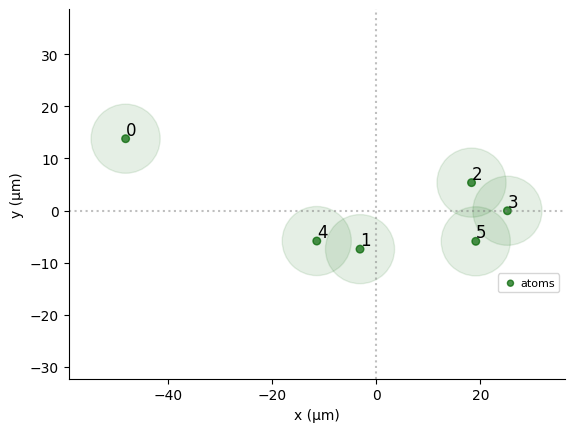

In [6]:
from pulser.devices import DigitalAnalogDevice
fig, ax = plt.subplots()
reg_8q.draw(
    blockade_radius=DigitalAnalogDevice.rydberg_blockade_radius(1.0),
    draw_graph=False,
    draw_half_radius=True,
    custom_ax = ax
)

In [7]:
from pulser.waveforms import ConstantWaveform, RampWaveform

import numpy as np

def run_algorithm(assigned_seq, n_samples=1000, seed=123):
    """Run the circuit simulating the evolution of the neutral atoms' device.

    Args:
        assigned_seq (pulser.Sequence): Sequence of the quantum algorithm, e.g., QAA or QAOA.
        n_samples (int): Number of samples to get.
        seed (int): Seed to see reproducible results.

    Return:
        count_dict (dict): Samples returned by the algorithm, keys: strings values: counts.
    """
    np.random.seed(seed)
    simul = QutipEmulator.from_sequence(assigned_seq, sampling_rate=0.01)
    results = simul.run()
    count_dict = results.sample_final_state(N_samples=n_samples)  # Sample from the state vector
    return count_dict

def get_cost_QUBO(bitstring, Q):
    """Evaluate the cost function."""
    z = np.array(list(bitstring), dtype=int)
    cost = z.T @ Q @ z
    return cost

def mean_cost(counter, Q):
    """Mean value of the cost for some samples."""
    cost = sum(counter[key] * get_cost_QUBO(key, Q) for key in counter)
    return cost / sum(counter.values())  # Divide by total samples

def approximation_ratio(counter, Q, min_energy, max_energy):
    """Approximation ratio."""
    mean_energy = mean_cost(counter, Q)
    r = (mean_energy - max_energy) / (min_energy - max_energy)
    return r

def QAOA(betas, gammas, reg, pulse_width=52, Omega_max=15.0, delta_max=20.0,
                 ramp_time=5, backend=DigitalAnalogDevice):
    """Quantum Approximate Optimization Algorithm.

    Args:
        betas (list): Parameters of the mixer Hamiltonian.
        gammas (list): Parameters of the problem Hamiltonian.
        pulse_width (int): Duration of the betas and the gammas pulses in [ns].
        Omega_max (float): Amplitude of the Rabi frequency in [rad/us].
        delta_max (float): Amplitude of the driving laser [rad/us].

    Return:
        assigned_seq (pulser.Sequence): QAOA sequence.
    """
    LAYERS = len(betas)  # Number p of the QAOA algorithm

    if len(gammas) != LAYERS:
        raise ValueError("betas and gammas have different size.")

    # Parametrized sequence
    seq = Sequence(reg, backend)
    ch0 = seq.declare_channel("ch0", "rydberg_global")

    t_list = seq.declare_variable("t_list", size=LAYERS)
    s_list = seq.declare_variable("s_list", size=LAYERS)

    # Initial state preparation - π/2 pulse to create superposition
    initial_omega_wf = ConstantWaveform(pulse_width//2, Omega_max/2)
    initial_delta_wf = ConstantWaveform(pulse_width//2, 0.0)

    # Create a pulse with the waveforms
    from pulser.pulse import Pulse
    initial_pulse = Pulse(initial_omega_wf, initial_delta_wf, 0)
    seq.add(initial_pulse, "ch0")

    for t, s in zip(t_list, s_list):
        # Problem Hamiltonian
        problem_omega_wf = ConstantWaveform(pulse_width, 0.0)

        # For the problem Hamiltonian, we need a constant detuning
        if ramp_time > 0 and ramp_time < pulse_width/2:
            # With ramping
            try:
                from pulser.waveforms import CompositeWaveform
                ramp_up = RampWaveform(ramp_time, 0.0, delta_max * s)
                middle = ConstantWaveform(pulse_width - 2*ramp_time, delta_max * s)
                ramp_down = RampWaveform(ramp_time, delta_max * s, 0.0)
                problem_delta_wf = CompositeWaveform(ramp_up, middle, ramp_down)
            except ImportError:
                # Fallback to constant if composite not available
                problem_delta_wf = ConstantWaveform(pulse_width, delta_max * s)
        else:
            # No ramping
            problem_delta_wf = ConstantWaveform(pulse_width, delta_max * s)

        problem_pulse = Pulse(problem_omega_wf, problem_delta_wf, 0)
        seq.add(problem_pulse, "ch0")

        # Mixer Hamiltonian
        mixer_delta_wf = ConstantWaveform(pulse_width, 0.0)

        if ramp_time > 0 and ramp_time < pulse_width/2:
            # With ramping
            try:
                from pulser.waveforms import CompositeWaveform
                ramp_up = RampWaveform(ramp_time, 0.0, Omega_max * t)
                middle = ConstantWaveform(pulse_width - 2*ramp_time, Omega_max * t)
                ramp_down = RampWaveform(ramp_time, Omega_max * t, 0.0)
                mixer_omega_wf = CompositeWaveform(ramp_up, middle, ramp_down)
            except ImportError:
                # Fallback to constant if composite not available
                mixer_omega_wf = ConstantWaveform(pulse_width, Omega_max * t)
        else:
            # No ramping
            mixer_omega_wf = ConstantWaveform(pulse_width, Omega_max * t)

        mixer_pulse = Pulse(mixer_omega_wf, mixer_delta_wf, 0)
        seq.add(mixer_pulse, "ch0")

    seq.measure("ground-rydberg")

    guess = {
        "t": [round(i, 5) for i in betas],
        "s": [round(i, 5) for i in gammas],
    }
    parameters = np.r_[guess["t"], guess["s"]]
    params = np.array(parameters)
    t_params, s_params = np.reshape(params.astype(float), (2, LAYERS))
    assigned_seq = seq.build(t_list=t_params, s_list=s_params)
    return assigned_seq


best_betas = [0.05519013445961409,
 0.5025500764489291,
 0.7687742552075342,
 0.744242259489458,
 0.38460759149661505,
 0.06479410819726242,
 0.5231175921543114,
 0.5656520254584226,
 0.5869648725405,
 0.29838198416285416]

best_gammas = [0.09291371525108409,
 1.0092881835892435,
 0.9099666162703384,
 0.42683444674630727,
 0.2081464649951845,
 0.16154146935115238,
 0.569030217250344,
 0.8081530600390686,
 0.9034267416582569,
 0.8065109667608715]

# Assuming 'reg_8q' and 'Q' are defined in your context
qaoa_seq = QAOA(best_betas, best_gammas, reg_8q)  # Sequence with the pulses of QAOA
sol_8q_qaoa = run_algorithm(qaoa_seq, n_samples=1000)  # Sampling the final state of the qaoa_seq

/usr/local/lib/python3.11/dist-packages/pulser/sequence/sequence.py:1281: UserWarning: A duration of 26 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 28 ns.
  self._add(pulse, channel, protocol)


In [8]:
sols_brute = [sol['solution_bitstring'] for sol in top_qubo_solutions]

# Print out the top solutions from QUBO sampling
print("Top QUBO solutions:")
sorted_qubo_solutions = sorted(sol_8q_qaoa.items(), key=lambda x: x[1], reverse=True)
for bitstring, count in sorted_qubo_solutions[:5]:
    cost = get_cost_QUBO(bitstring, Q)
    print(f"Bitstring: {bitstring}, Count: {count}, Cost: {cost}")

print("\nBrute Force solutions:")
if 'sols_brute' in locals():
    for sol in sols_brute:
        cost = get_cost_QUBO(sol, Q)
        count = sol_8q_qaoa.get(sol, 0)
        print(f"Bitstring: {sol}, Count: {count}, Cost: {cost}")

Top QUBO solutions:
Bitstring: 111001, Count: 160, Cost: -39.0
Bitstring: 101011, Count: 157, Cost: -34.8
Bitstring: 100110, Count: 72, Cost: -30.0
Bitstring: 101001, Count: 70, Cost: -24.799999999999997
Bitstring: 111011, Count: 63, Cost: -19.0

Brute Force solutions:
Bitstring: 111001, Count: 160, Cost: -39.0
Bitstring: 101011, Count: 157, Cost: -34.8
Bitstring: 111000, Count: 5, Cost: -34.2
Bitstring: 110001, Count: 1, Cost: -33.6
Bitstring: 110100, Count: 58, Cost: -33.6


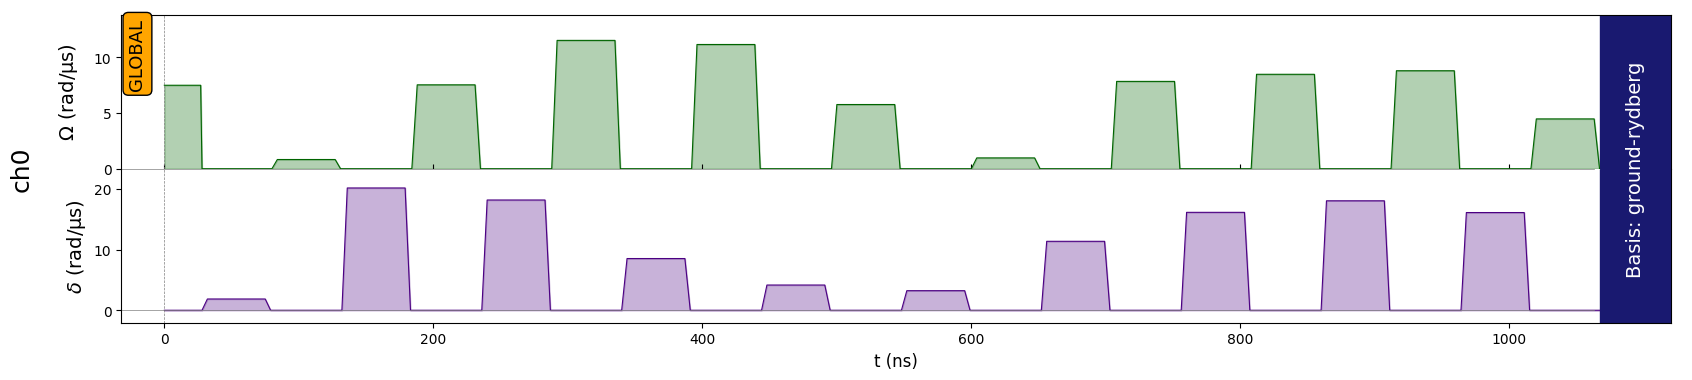

In [9]:
qaoa_seq.draw(kwargs_savefig={"bbox_inches":"tight"})

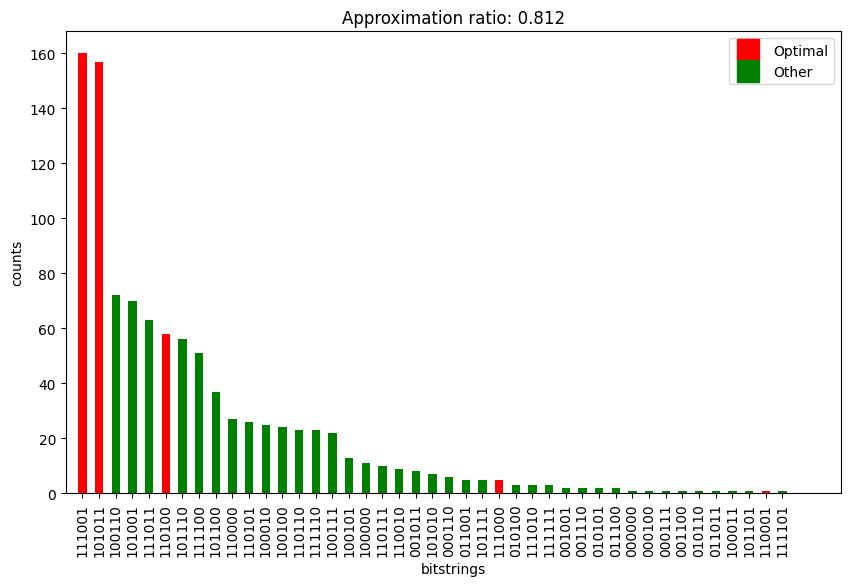

In [10]:
def plot_distribution(C, sols, ax):
    C = dict(sorted(C.items(), key=lambda item: item[1], reverse=True))
    color_dict = {key: "r" if key in sols else "g" for key in C}
    ax.set_xlabel("bitstrings")
    ax.set_ylabel("counts")
    ax.bar(C.keys(), C.values(), width=0.5, color=color_dict.values())
    plt.xticks(rotation="vertical", fontsize=10)


fig, ax = plt.subplots(figsize=(10, 6))
r = approximation_ratio(sol_8q_qaoa, Q, cost_min, cost_max)
plot_distribution(sol_8q_qaoa, sols_brute, ax)
ax.plot([],[], marker="s", color="red", label="Optimal", linewidth=0, markersize=16)
ax.plot([],[], marker="s", color="green", label="Other", linewidth=0, markersize=16)
ax.set_title(f"Approximation ratio: {round(r,3)}")
ax.set_xlim(-1,45.5)
ax.legend();
#fig.savefig("./Figures/hist_qaoa_q8.png", bbox_inches="tight")



In [11]:
def QAA(Omega, reg, delta_0 = -5, delta_f=5, T=4000, backend=DigitalAnalogDevice):
    """ Quantum Adiabatic Algorithm

        Args:

        Omega (float): Maximum amplitude of the Raby frequency in [rad/us]
        reg (pulser.Register): Pulser register with the information of the atoms
        delta_0 (float): Minimum detuning of the protocol [rad/us]
        delta_f (float): Maximum detuning of the protocol [rad/us]
        T (int): time of the annealing protocol in [ns]

        Return:
        Sed (pulser.Sequence): sequence with the annealing evolution.

    """
    adiabatic_pulse = Pulse(
        InterpolatedWaveform(T, [1e-9, Omega, 1e-9]),
        InterpolatedWaveform(T, [delta_0, 0, delta_f]),
        0,
    )
    seq = Sequence(reg, backend)
    seq.declare_channel("ising", "rydberg_global")
    seq.add(adiabatic_pulse, "ising")
    return seq


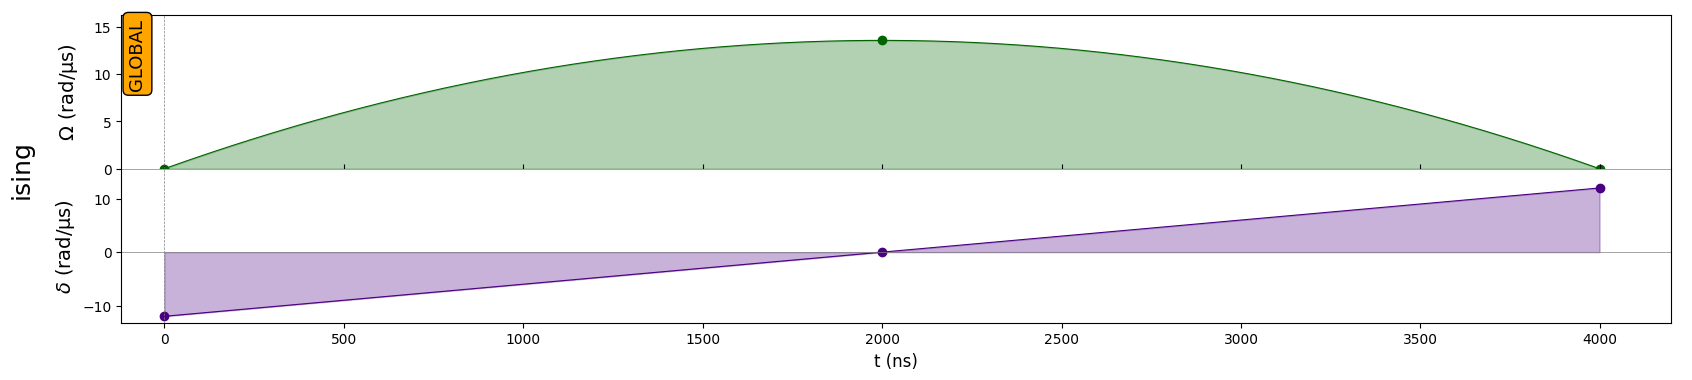

In [12]:
# We choose a median value between the min and the max
Omega = np.median(Q[Q > 0].flatten())

delta_0 = - 12  # just has to be negative
delta_f = - delta_0  # just has to be positive
T = 4000  # time in ns, we choose a time long enough to ensure the propagation of information in the system

seq_qaa = QAA(Omega, reg_8q, delta_0, delta_f, T)
seq_qaa.draw(kwargs_savefig={"bbox_inches":"tight"})


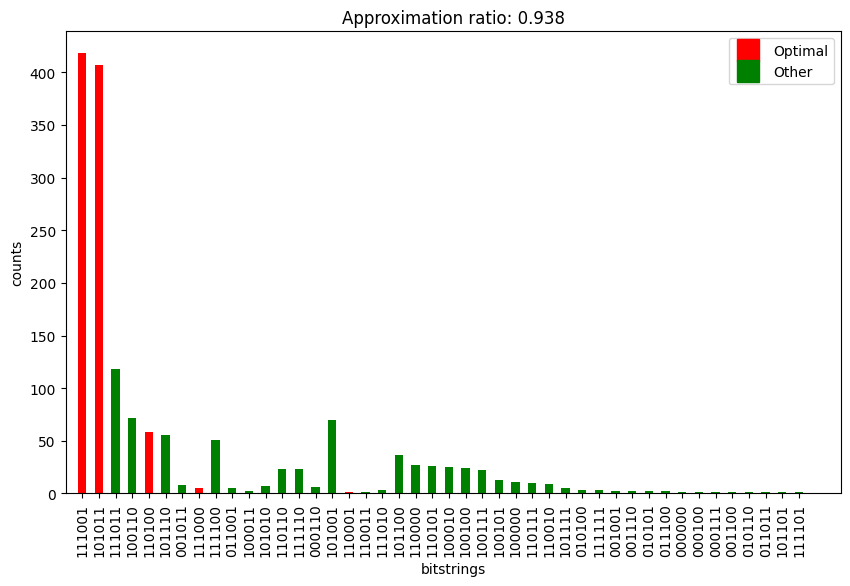

In [13]:
sol_8q_qaa = run_algorithm(seq_qaa)

fig, ax = plt.subplots(figsize=(10, 6))
plot_distribution(sol_8q_qaa, sols_brute, ax)
ax.plot([],[], marker="s", color="red", label="Optimal", linewidth=0, markersize=16)
ax.plot([],[], marker="s", color="green", label="Other", linewidth=0, markersize=16)
r = approximation_ratio(sol_8q_qaa, Q, cost_min, cost_max)
plot_distribution(sol_8q_qaoa, sols_brute, ax)
ax.set_title(f"Approximation ratio: {round(r,3)}")
ax.set_xlim(-1,45.5)
ax.legend();
#fig.savefig("./Figures/r_qaa_q8.png", bbox_inches="tight")